In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import random
import os
import cv2
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from PIL import Image
from PIL import ImageFilter

In [2]:
# Helper function to do one hot encoding for labels
def encode_label(labels):
    target = np.zeros(9, dtype='int')
    for l in labels:
        target[l] = 1
    return target
def encode_new_label(labels):
    target = np.zeros(5, dtype='int')
    for i in range(len(labels)):
        if labels[i] == 0:
            target[0] = 1
        if labels[i] == 1:
            target[1] = 1
        if labels[i] == 4:
            target[2] = 1
        if labels[i] == 5:
            target[3] = 1
        if labels[i] == 8:
            target[4] = 1
    return target

In [3]:
# Helper function transfer path to tensorflow images
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(tensors)

In [4]:
# Helper function to print loss function and accuracy history
def history(model):
    plt.figure(figsize = (15, 5) )

    plt.subplot(121)
    plt.plot(model.history['loss'], color='blue', label='train')
    plt.plot(model.history['val_loss'], color='red', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')

    plt.subplot(122)
    plt.plot(model.history['binary_accuracy'], color = 'blue', label='train')
    plt.plot(model.history['val_binary_accuracy'], color='red', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

In [5]:
# Helper function to calculate results
def true_pos(y_true, y_pred):
    return np.sum(y_true * y_pred)


def false_pos(y_true, y_pred):
    return np.sum(y_true * (1. - y_pred))


def false_neg(y_true, y_pred):
    return np.sum((1. - y_true) * y_pred)


def precision(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_pos(y_true, y_pred))


def recall(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_neg(y_true, y_pred))


def f1_score(y_true, y_pred):
    return 2. / (1. / recall(y_true, y_pred) + 1. / precision(y_true, y_pred))

### Preprocess

In [6]:
# Business id to labels
biz2labels = pd.read_csv('Data/train.csv', header = 0, names = ['business','labels']).fillna('')

# Photo id to business id for the training dataset
photo2biz_train = pd.read_csv('Data/train_photo_to_biz_ids.csv', header = 0, names = ['photo','business'])

# Get list of photo id 
photo_ids = np.array(photo2biz_train['photo'])

print('There are %d training images' % len(photo_ids))

There are 234842 training images


In [7]:
biz2labels['labels'] = biz2labels['labels'].apply(lambda x: tuple(sorted(int(t) for t in x.split())))
biz2labels.set_index('business', inplace=True)
biz2labels.head(n=10)

,labels
business,
1000,"(1, 2, 3, 4, 5, 6, 7)"
1001,"(0, 1, 6, 8)"
100,"(1, 2, 4, 5, 6, 7)"
1006,"(1, 2, 4, 5, 6)"
1010,"(0, 6, 8)"
101,"(1, 2, 3, 4, 5, 6)"
1011,"(2, 3, 5, 6)"
1012,"(1, 2, 3, 5, 6)"
1014,"(1, 2, 4, 5, 6)"


In [8]:
biz2labels['new_label'] = [[0]]*len(biz2labels)
for i in biz2labels.index:
    biz2labels.at[i, 'new_label'] = tuple(i for i in biz2labels.loc[i]['labels'] if i in [0,1,4,5,8])
biz2labels.head(n=10)

,labels,new_label
business,,
1000,"(1, 2, 3, 4, 5, 6, 7)","(1, 4, 5)"
1001,"(0, 1, 6, 8)","(0, 1, 8)"
100,"(1, 2, 4, 5, 6, 7)","(1, 4, 5)"
1006,"(1, 2, 4, 5, 6)","(1, 4, 5)"
1010,"(0, 6, 8)","(0, 8)"
101,"(1, 2, 3, 4, 5, 6)","(1, 4, 5)"
1011,"(2, 3, 5, 6)","(5,)"
1012,"(1, 2, 3, 5, 6)","(1, 5)"
1014,"(1, 2, 4, 5, 6)","(1, 4, 5)"


In [9]:
photo_targets = np.vstack(biz2labels.loc[photo2biz_train['business']]['new_label'].apply(encode_new_label))
print('Number of rows: %d - Number of columns: %d' % (photo_targets.shape[0], photo_targets.shape[1]))

Number of rows: 234842 - Number of columns: 5


In [10]:
from sklearn.model_selection import train_test_split

train_files, test_files, train_targets, test_targets = train_test_split(photo_ids,
                                                                        photo_targets,
                                                                        test_size=0.25,
                                                                        random_state=7)

valid_files, valid_targets = (test_files[:int(len(test_files)/2)], test_targets[:int(len(test_files)/2)])
test_files, test_targets = (test_files[int(len(test_files)/2):], test_targets[int(len(test_files)/2):])

print('There are %d images in the training dataset' % len(train_files))
print('There are %d images in the validation dataset' % len(valid_files))
print('There are %d images in the test dataset' % len(test_files))

There are 176131 images in the training dataset
There are 29355 images in the validation dataset
There are 29356 images in the test dataset


In [11]:
# Load Pictures
train_files = np.array(['Data/train_photos/' + str(i) + '.jpg' for i in train_files])
valid_files = np.array(['Data/train_photos/' + str(i) + '.jpg' for i in valid_files])
test_files = np.array(['Data/train_photos/' + str(i) + '.jpg' for i in test_files])

print('There are %d images in the training dataset' % len(train_files))
print('There are %d images in the validation dataset' % len(valid_files))
print('There are %d images in the test dataset' % len(test_files))

There are 176131 images in the training dataset
There are 29355 images in the validation dataset
There are 29356 images in the test dataset


In [12]:
# Number of pictures to process for each dataset
nb_train, nb_valid, nb_test = (20000,2000,2000)

### ResNet50

In [14]:
train_tensors = preprocess_input(paths_to_tensor(train_files[:nb_train]))
valid_tensors = preprocess_input(paths_to_tensor(valid_files[:nb_valid]))
test_tensors = preprocess_input(paths_to_tensor(test_files[:nb_test]))

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 483.89it/s]


In [15]:
model = ResNet50(include_top=False)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [16]:
train_resnet50 = model.predict(train_tensors)
valid_resnet50 = model.predict(valid_tensors)
test_resnet50  = model.predict(test_tensors)

2022-05-31 19:11:51.002201: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [17]:
np.savez('yelp_resnet50_5.npz', 
         train_features=train_resnet50, train_targets=train_targets[:nb_train],
         valid_features=valid_resnet50, valid_targets=valid_targets[:nb_valid],
         test_features=test_resnet50, test_targets=test_targets[:nb_test])

In [18]:
bottleneck_features = np.load('yelp_resnet50_5.npz')
train_resnet50 = bottleneck_features['train_features']
valid_resnet50 = bottleneck_features['valid_features']
test_resnet50 = bottleneck_features['test_features']

train_targets = bottleneck_features['train_targets']
valid_targets = bottleneck_features['valid_targets']
test_targets = bottleneck_features['test_targets']

In [22]:
# Create Model
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, MaxPooling2D 
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.regularizers import l2

resnet50 = Sequential()
resnet50.add(GlobalAveragePooling2D(input_shape=train_resnet50.shape[1:]))

resnet50.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
resnet50.add(BatchNormalization())
resnet50.add(Dropout(0.3))

resnet50.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
resnet50.add(BatchNormalization())
resnet50.add(Dropout(0.3))

resnet50.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
resnet50.add(BatchNormalization())

resnet50.add(Dense(5, activation='sigmoid'))

resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_4 (Batc  (None, 512)             

In [23]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
resnet50.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath='weights_compare_resnet50_5.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)

history_resnet50 = resnet50.fit(train_resnet50, train_targets, 
                                validation_data=(valid_resnet50,valid_targets), 
                                epochs=1000, batch_size=64,
                                callbacks=[checkpointer,checkimprovement]
                               )

Epoch 1/1000
313/313 [==============================] - 5s 15ms/step - loss: 1.0816 - binary_accuracy: 0.5268 - val_loss: 0.9374 - val_binary_accuracy: 0.5784
Epoch 2/1000
313/313 [==============================] - 4s 12ms/step - loss: 1.0167 - binary_accuracy: 0.5681 - val_loss: 0.9127 - val_binary_accuracy: 0.6136
Epoch 3/1000
313/313 [==============================] - 4s 12ms/step - loss: 0.9785 - binary_accuracy: 0.5945 - val_loss: 0.8903 - val_binary_accuracy: 0.6406
Epoch 4/1000
313/313 [==============================] - 4s 12ms/step - loss: 0.9521 - binary_accuracy: 0.6161 - val_loss: 0.8734 - val_binary_accuracy: 0.6563
Epoch 5/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.9314 - binary_accuracy: 0.6309 - val_loss: 0.8591 - val_binary_accuracy: 0.6694
Epoch 6/1000
313/313 [==============================] - 4s 12ms/step - loss: 0.9155 - binary_accuracy: 0.6402 - val_loss: 0.8496 - val_binary_accuracy: 0.6764
Epoch 7/1000
313/313 [========================

313/313 [==============================] - 4s 13ms/step - loss: 0.6799 - binary_accuracy: 0.7912 - val_loss: 0.7203 - val_binary_accuracy: 0.7724
Epoch 104/1000
313/313 [==============================] - 4s 12ms/step - loss: 0.6785 - binary_accuracy: 0.7916 - val_loss: 0.7201 - val_binary_accuracy: 0.7732
Epoch 105/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6780 - binary_accuracy: 0.7926 - val_loss: 0.7200 - val_binary_accuracy: 0.7726
Epoch 106/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6765 - binary_accuracy: 0.7931 - val_loss: 0.7195 - val_binary_accuracy: 0.7724
Epoch 107/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6786 - binary_accuracy: 0.7922 - val_loss: 0.7192 - val_binary_accuracy: 0.7717
Epoch 108/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6756 - binary_accuracy: 0.7933 - val_loss: 0.7192 - val_binary_accuracy: 0.7726
Epoch 109/1000
313/313 [=========================

Epoch 154/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6463 - binary_accuracy: 0.8088 - val_loss: 0.7157 - val_binary_accuracy: 0.7746
Epoch 155/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6431 - binary_accuracy: 0.8115 - val_loss: 0.7152 - val_binary_accuracy: 0.7741
Epoch 156/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6431 - binary_accuracy: 0.8106 - val_loss: 0.7152 - val_binary_accuracy: 0.7745
Epoch 157/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6409 - binary_accuracy: 0.8134 - val_loss: 0.7156 - val_binary_accuracy: 0.7750
Epoch 158/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6435 - binary_accuracy: 0.8110 - val_loss: 0.7148 - val_binary_accuracy: 0.7758
Epoch 159/1000
313/313 [==============================] - 4s 13ms/step - loss: 0.6411 - binary_accuracy: 0.8119 - val_loss: 0.7151 - val_binary_accuracy: 0.7755
Epoch 160/1000
313/313 [==========

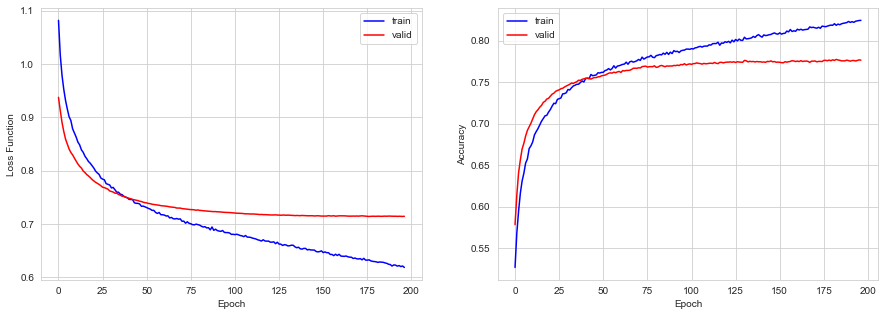

In [25]:
history(history_resnet50)

In [26]:
resnet50.load_weights('weights_compare_resnet50_5.hdf5')

In [27]:
resnet50_predictions = (resnet50.predict(test_resnet50) >= 0.5).astype(int)

In [28]:
resnet50_score = f1_score(test_targets, resnet50_predictions)
print('F1 score: %.5f' % resnet50_score)

F1 score: 0.76888


### Inception V3

In [29]:
from keras.applications.inception_v3 import preprocess_input

train_tensors = preprocess_input(paths_to_tensor(train_files[:nb_train]))
valid_tensors = preprocess_input(paths_to_tensor(valid_files[:nb_valid]))
test_tensors = preprocess_input(paths_to_tensor(test_files[:nb_test]))

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 488.97it/s]


In [30]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(include_top=False)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, None, None,   96         ['conv2d[0][0]']                 
 rmalization)                   32)                                                    

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_20 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_25[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_27[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_37 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_42 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_51 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_54[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_55[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_64 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_65 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_56[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_77 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_81 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_77[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_81[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_85[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_88[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_89[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_98 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_91 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

In [31]:
train_inception = model.predict(train_tensors)
valid_inception = model.predict(valid_tensors)
test_inception  = model.predict(test_tensors)

In [32]:
np.savez('yelp_inception_5.npz', 
         train_features=train_inception, train_targets=train_targets[:nb_train],
         valid_features=valid_inception, valid_targets=valid_targets[:nb_valid],
         test_features=test_inception, test_targets=test_targets[:nb_test])

In [33]:
bottleneck_features = np.load('yelp_inception_5.npz')
train_inception = bottleneck_features['train_features']
valid_inception = bottleneck_features['valid_features']
test_inception = bottleneck_features['test_features']

train_targets = bottleneck_features['train_targets']
valid_targets = bottleneck_features['valid_targets']
test_targets = bottleneck_features['test_targets']

In [34]:
inception = Sequential()
inception.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))

inception.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4),
                                             bias_regularizer=l2(1e-4),
                                             activity_regularizer=l2(1e-5)))
inception.add(BatchNormalization())
inception.add(Dropout(0.3))

inception.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4),
                                             bias_regularizer=l2(1e-4),
                                             activity_regularizer=l2(1e-5)))
inception.add(BatchNormalization())
inception.add(Dropout(0.3))

inception.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4),
                                             bias_regularizer=l2(1e-4),
                                             activity_regularizer=l2(1e-5)))
inception.add(BatchNormalization())
inception.add(Dropout(0.3))

inception.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4),
                                             bias_regularizer=l2(1e-4),
                                             activity_regularizer=l2(1e-5)))
inception.add(BatchNormalization())
inception.add(Dropout(0.3))

inception.add(Dense(5, activation='sigmoid'))

inception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_100 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_101 (Ba  (None, 512)             

In [35]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.9, epsilon=1e-06)
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
inception.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['binary_accuracy'])
checkpointer = ModelCheckpoint(filepath='weights_compare_inception_5.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_binary_accuracy', min_delta=0, patience=20)

history_inception = inception.fit(train_inception, train_targets, 
                                validation_data=(valid_inception,valid_targets), 
                                epochs=1000, batch_size=128,
                                callbacks=[checkpointer,checkimprovement]
                               )

Epoch 1/1000
157/157 [==============================] - 3s 17ms/step - loss: 0.9508 - binary_accuracy: 0.6583 - val_loss: 0.8086 - val_binary_accuracy: 0.7361
Epoch 2/1000
157/157 [==============================] - 3s 17ms/step - loss: 0.8123 - binary_accuracy: 0.7319 - val_loss: 0.7857 - val_binary_accuracy: 0.7395
Epoch 3/1000
157/157 [==============================] - 2s 16ms/step - loss: 0.7748 - binary_accuracy: 0.7427 - val_loss: 0.7700 - val_binary_accuracy: 0.7446
Epoch 4/1000
157/157 [==============================] - 3s 16ms/step - loss: 0.7506 - binary_accuracy: 0.7516 - val_loss: 0.7513 - val_binary_accuracy: 0.7449
Epoch 5/1000
157/157 [==============================] - 3s 16ms/step - loss: 0.7321 - binary_accuracy: 0.7548 - val_loss: 0.7559 - val_binary_accuracy: 0.7385
Epoch 6/1000
157/157 [==============================] - 3s 17ms/step - loss: 0.7131 - binary_accuracy: 0.7601 - val_loss: 0.7627 - val_binary_accuracy: 0.7305
Epoch 7/1000
157/157 [========================

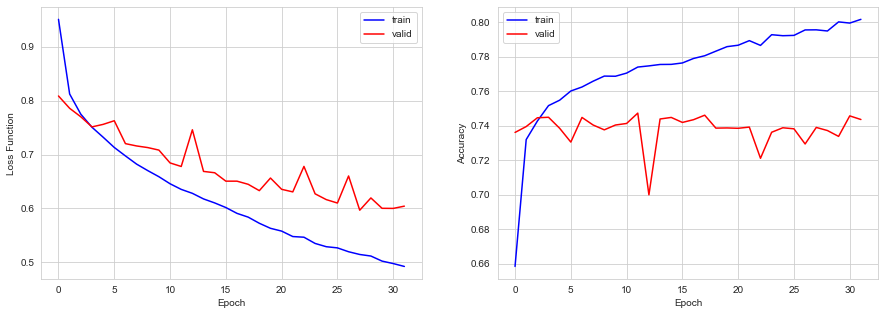

In [36]:
history(history_inception)

In [38]:
inception.load_weights('weights_compare_inception_5.hdf5')

In [39]:
inception_predictions = (inception.predict(test_inception) >= 0.5).astype(int)

In [40]:
inception_score = f1_score(test_targets, inception_predictions)
print('F1 score: %.5f' % inception_score)

F1 score: 0.72132
